In [192]:
import math
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import randint as sp_randint

from sklearn.decomposition import PCA

In [193]:
style.use("ggplot")

In [194]:
# loading the data
portfolio = ["NVDA", "MSFT", "AAPL", "META", "TSLA", "LMT", "GS", "GM", "CAT", "AMZN", "NFLX", "WMT", "^DJI"]
df = yf.download(portfolio, start="2014-01-01")["Adj Close"]

# Visualizing the dataframe
df.head()

[*********************100%***********************]  13 of 13 completed


,AAPL,AMZN,CAT,GM,GS,LMT,META,MSFT,NFLX,NVDA,TSLA,WMT,^DJI
Date,,,,,,,,,,,,,
2014-01-02,17.341545,19.898500,68.470024,31.347300,149.211990,112.579071,54.709999,31.354326,51.831429,3.741360,10.006667,64.015533,16441.349609
2014-01-03,16.960619,19.822001,68.431915,30.290913,150.274796,113.342072,54.560001,31.143394,51.871429,3.696538,9.970667,63.804615,16469.990234
2014-01-06,17.053104,19.681499,67.532906,30.926273,151.303986,112.740936,57.200001,30.485250,51.367142,3.746078,9.800000,63.447662,16425.099609
2014-01-07,16.931147,19.901501,67.753860,30.773178,150.392899,114.536728,57.919998,30.721502,48.500000,3.807412,9.957333,63.642357,16530.939453
2014-01-08,17.038378,20.096001,67.913849,30.941586,150.519470,114.451927,58.230000,30.173052,48.712856,3.859309,10.085333,63.139378,16462.740234


In [195]:
# Dropping 'Not a Number' columns for Dow Chemicals (DWDP) and Visa (V)
# df.drop(['DWDP', 'V'], axis=1, inplace=True)
# Copying the dataframe to add features
data = pd.DataFrame(df.copy())

In [196]:
# Daily Returns
# Daily Log Returns (%)
# datareturns = np.log(data / data.shift(1)) 

# Daily Linear Returns (%)
datareturns = data.pct_change(1)

In [197]:
# Data Raw
data_raw = datareturns
data_raw.dropna(how='all', inplace=True)

In [198]:
# Normalizing the Log returns
data = (data_raw - data_raw.mean()) / data_raw.std()

# Getting rid of the NaN values.
data.dropna(how='any', inplace=True)
data_raw.dropna(how='any', inplace=True)

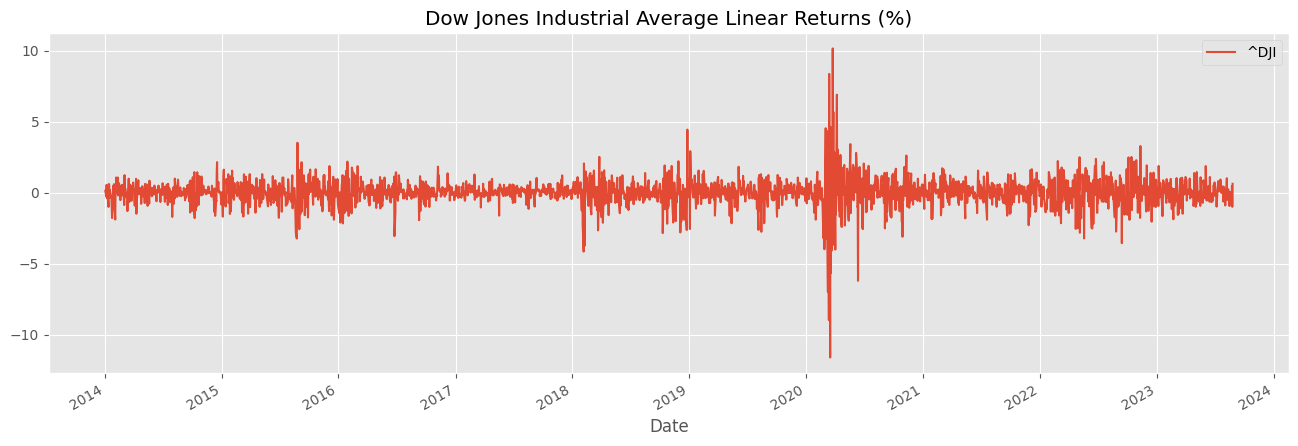

In [199]:
# Visualizing Log Returns for the DJIA 
plt.figure(figsize=(16, 5))
plt.title("Dow Jones Industrial Average Linear Returns (%)")
data["^DJI"].plot()
plt.grid(True);
plt.legend()
plt.show()

In [200]:
# Taking away the market benchmark DJIA
stock_tickers = data.columns.values[:-1]
n_tickers = len(stock_tickers)

In [201]:
# Dividing the dataset into training and testing sets
percentage = int(len(data) * 0.8)
X_train = data[:percentage]
X_test = data[percentage:]

X_train_raw = data_raw[:percentage]
X_test_raw = data_raw[percentage:]

In [202]:
# Applying Principle Component Analysis
# Creating covariance matrix and training data on PCA.
cov_matrix = X_train.loc[:,X_train.columns != '^DJI'].cov()
pca = PCA()
pca.fit(cov_matrix)

PCA()

9 principal components explain 95.00% of variance


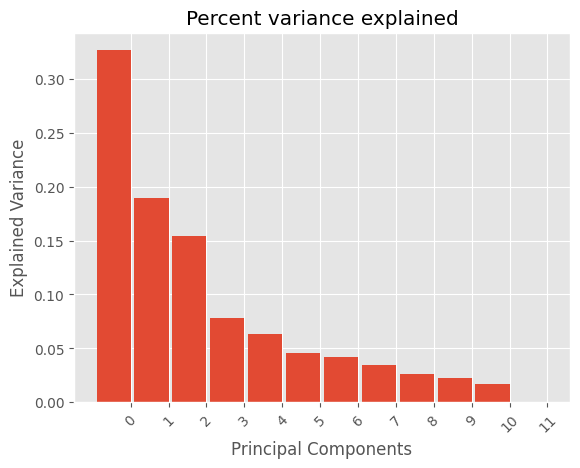

In [203]:
def plotPCA(plot=False):

    # Visualizing Variance against number of principal components.
    cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != 'DJIA'].cov()

    var_threshold = 0.95
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = stock_tickers.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(plot=True)

In [204]:
projected = pca.fit_transform(cov_matrix)
pcs = pca.components_

In [205]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #2 with the highest Sharpe. Return nan%, vol = 507.33%, Sharpe = nan
      Return       Vol    Sharpe
8  -0.418053  2.467500 -0.169424
0  -0.970377  3.130075 -0.310017
1  -0.963471  2.970424 -0.324355
10 -0.980614  2.614066 -0.375130
11 -0.918368  2.389783 -0.384289


C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1356574605.py:10: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1356574605.py:10: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1356574605.py:10: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1356574605.py:10: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1356574605.py:10: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1356574605.py:10: RuntimeWa

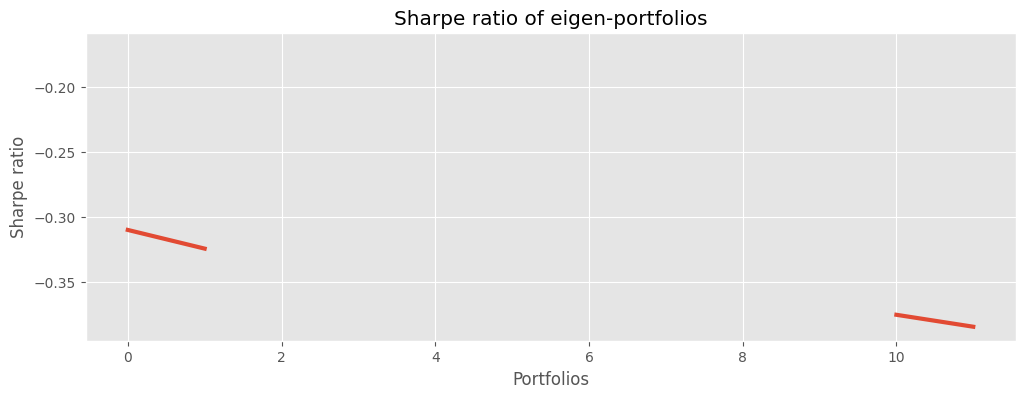

In [206]:
def optimizedPortfolio():
    n_portfolios = len(pcs)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 

    for i in range(n_portfolios):
        
        pc_w = pcs[:, i] / sum(pcs[:, i])
        eigen_prtfi = pd.DataFrame(data={'weights': pc_w.squeeze()*100}, index=stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen_prtfi / n_portfolios)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(10))

    plt.show()

optimizedPortfolio()

C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1539379651.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))


Sum of weights of current eigen-portfolio: 100.00


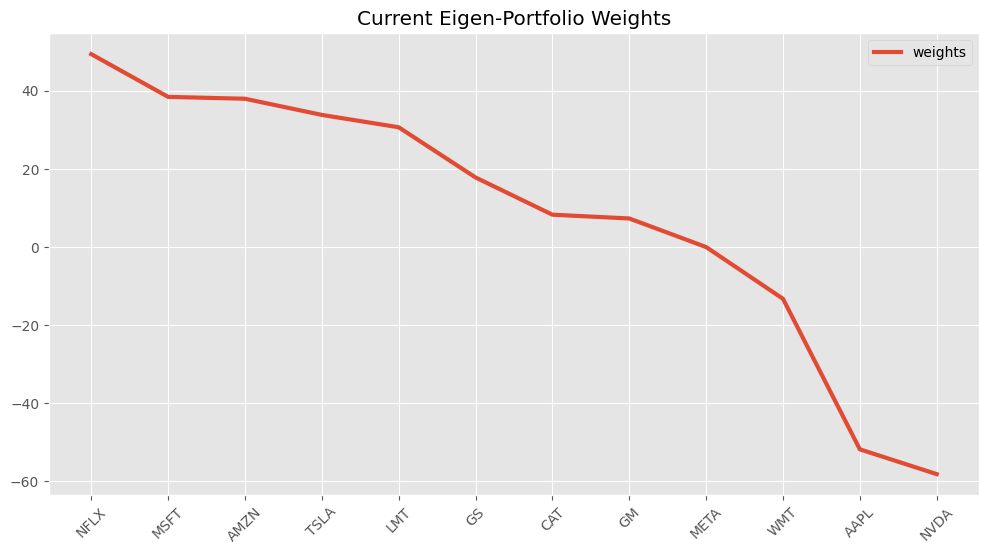

,weights
NFLX,49.387042
MSFT,38.431810
AMZN,37.951044
TSLA,33.810944
LMT,30.643038
GS,17.777890
CAT,8.239036
GM,7.268683
META,-0.054840
WMT,-13.312110


In [207]:
def PCWeights():
    '''
    Principal Components (PC) weights for each PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights = PCWeights()
portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[4], plot=True)

C:\Users\Jack\AppData\Local\Temp\ipykernel_3352\1356574605.py:10: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1


Current Eigen-Portfolio:
Return = nan%
Volatility = 354.89%
Sharpe = nan


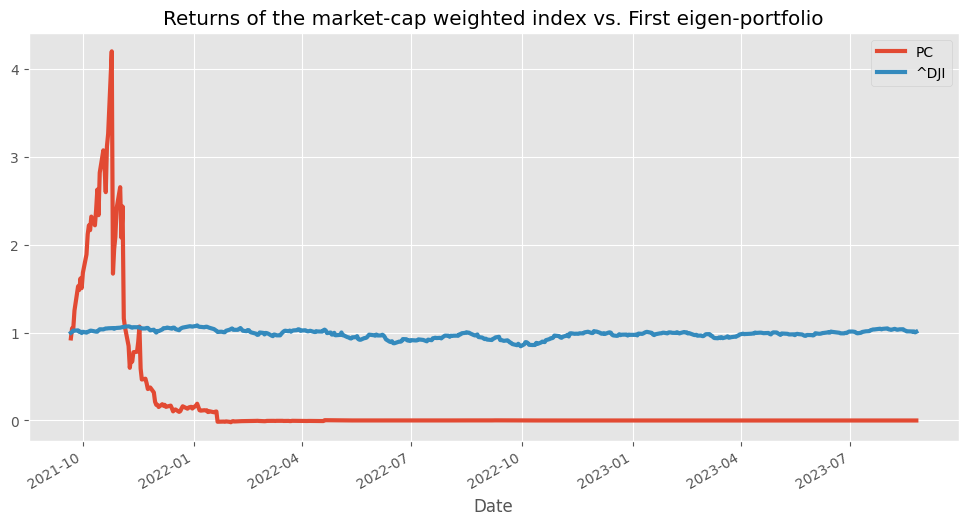

In [208]:
def plotSharpe(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''

    eigen_portfolio_returns = np.dot(X_test_raw.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=X_test.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    year_frac = (eigen_portfolio_returns.index[-1] - eigen_portfolio_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC': eigen_portfolio_returns, '^DJI': X_test_raw.loc[:, '^DJI']}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)
    plt.show()

plotSharpe(eigen=plotEigen(weights=weights[4]))